# Principal Componenet Analysis of Citi Surprise Index for Trading G10 Carry Index

## Packages

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
from   sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [4]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
from CitiPCA import PCAModel

## Going through backtests

In [6]:
df_signal, df_params = PCAModel().full_sample_ols_index_backtest()

It is not intuitive on how many principal components to use to decompose the data, before running OLS. Instead begin with just looping through all possible components and then run the regression

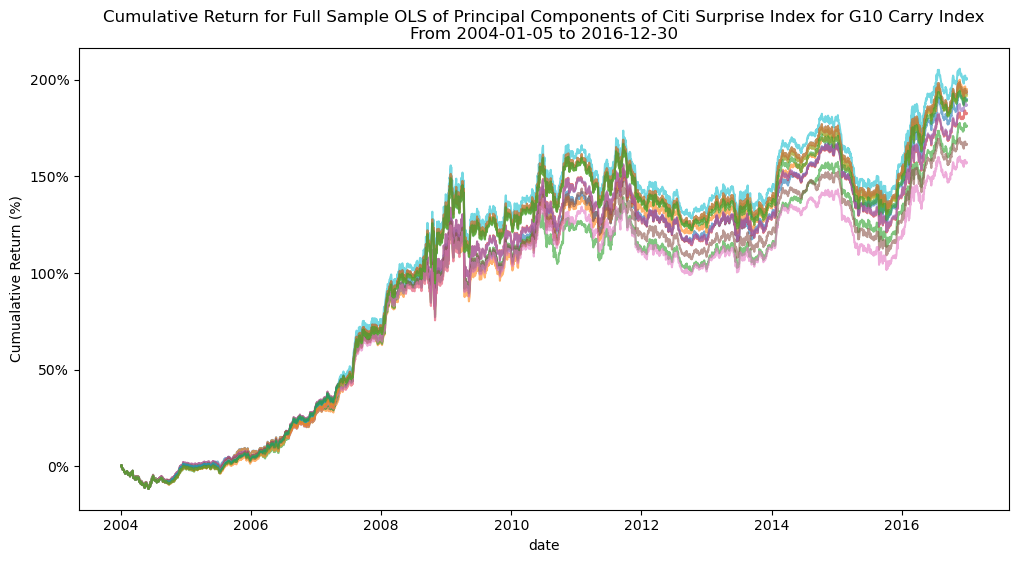

In [8]:
def plot_cumulative_return(df_signal: pd.DataFrame) -> pd.DataFrame: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_signal.assign(
        signal_rtn = lambda x: -1 * np.sign(x.lag_resid) * x.rtn)
        [["date", "pcs", "signal_rtn"]].
        pivot(index = "date", columns = "pcs", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ylabel = "Cumualative Return (%)",
            ax     = axes,
            legend = False,
            alpha  = 0.6,
            title  = "Cumulative Return for Full Sample OLS of Principal Components of Citi Surprise Index for G10 Carry Index\nFrom {} to {}".format(
                df_signal.date.min(),
                df_signal.date.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

plot_cumulative_return(df_signal)

In [9]:
def get_params(df_signal: pd.DataFrame) -> pd.DataFrame: 

    df_stats = (df_signal.assign(
        signal_rtn = lambda x: -1 * np.sign(x.lag_resid) * x.rtn)
        [["pcs", "signal_rtn"]].
        groupby("pcs").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))

    return df_stats

df_stats = get_params(df_signal)

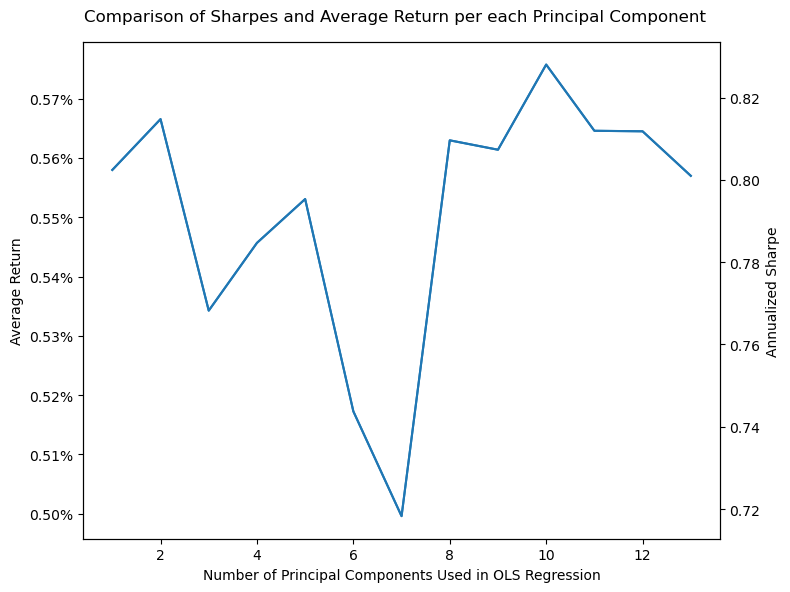

In [10]:
def plot_stats_comaprison(df_stats: pd.DataFrame) -> plt.Figure: 

    fig, axes  = plt.subplots(figsize = (8,6))
    twinx_copy = axes.twinx()
    
    (df_stats[
        ["mean_rtn"]].
        apply(lambda x: x * np.sqrt(252)).
        plot(
            ax     = axes, 
            legend = False,
            ylabel = "Average Return"))
    
    (df_stats[
        ["sharpe"]].
        plot(
            ax     = twinx_copy, 
            legend = False,
            ylabel = "Annualized Sharpe"))
    
    fig.suptitle("Comparison of Sharpes and Average Return per each Principal Component")
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.2f}%"))
    axes.set_xlabel("Number of Principal Components Used in OLS Regression")
    
    plt.tight_layout()

plot_stats_comaprison(df_stats)

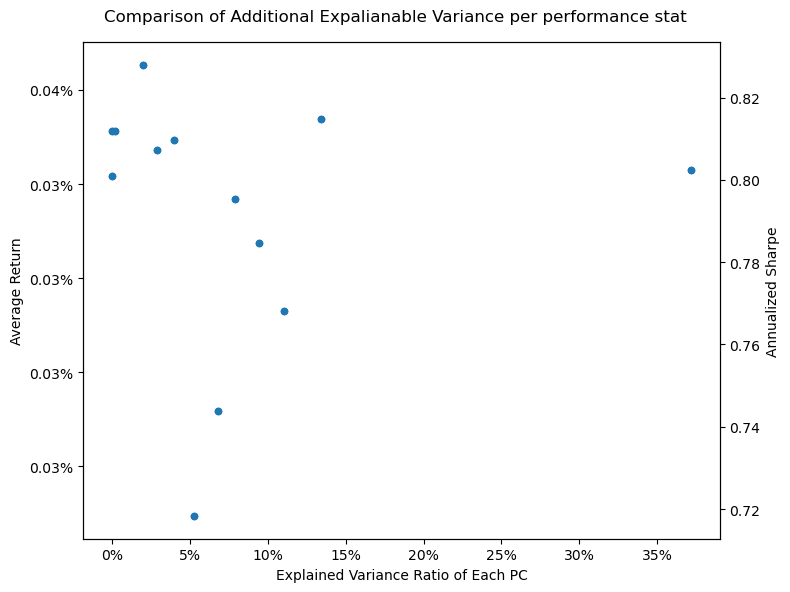

In [11]:
def plot_variance_stat(df_stats: pd.DataFrame) -> plt.Figure: 

    df_longer = (df_stats.drop(
        columns = "std_rtn").
        reset_index().
        melt(id_vars = "pcs").
        rename(columns = {"pcs": "pc"}).
        assign(pc = lambda x: x.pc.astype(int)))
    
    df_var = (PCAModel().pca()[
        ["pc", "explained_variance_ratio"]].
        drop_duplicates().
        assign(pc = lambda x: x.pc.str.replace("PC", "").astype(int)))
    
    df_combined = (df_longer.merge(
        right = df_var, how = "inner", on = ["pc"]))
    
    stats      = df_combined.variable.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(figsize = (8,6))
    twinx_axes = axes.twinx()
    axes_list  = [axes, twinx_axes]
    
    renamer = {
        "mean_rtn": "Average Return",
        "sharpe"  : "Annualized Sharpe"}
    
    for stat, ax in zip(stats, axes_list): 
    
        (df_combined.query(
            "variable == @stat").
            plot(
                kind   = "scatter", 
                x      = "explained_variance_ratio", 
                y      = "value",
                ax     = ax,
                ylabel = renamer[stat],
                xlabel = "Explained Variance Ratio of Each PC"))
    
        if stat == "mean_rtn": axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.2f}%"))
    
    axes.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    fig.suptitle("Comparison of Additional Expalianable Variance per performance stat")
    plt.tight_layout()

plot_variance_stat(df_stats)

Now find the number of principal componets to use from the data

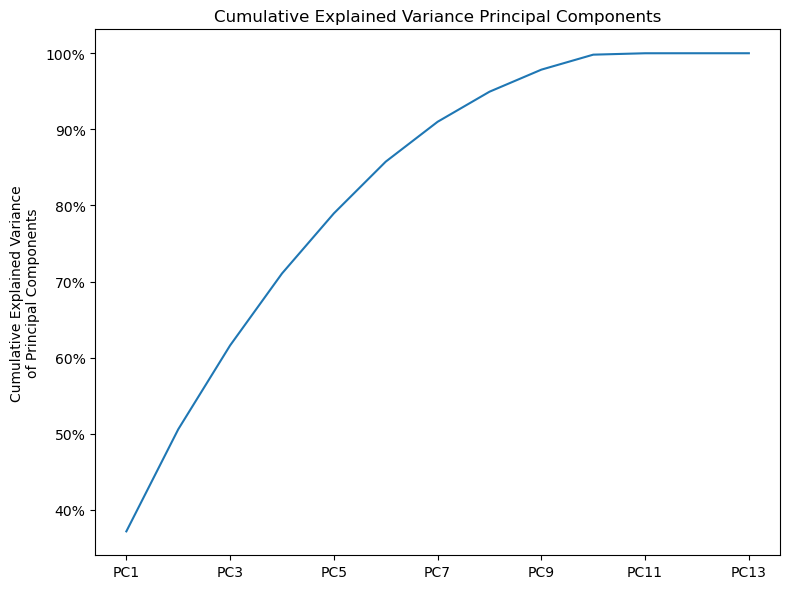

In [13]:
def plot_cumulative_explained_variance_ratio() -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (8,6))
    
    (PCAModel().pca().set_index(
        "pc")
        [["explained_variance_ratio"]].
        drop_duplicates().
        cumsum().
        plot(
            ax     = axes,
            legend = False,
            ylabel = "Cumulative Explained Variance\nof Principal Components",
            xlabel = "",
            title  = "Cumulative Explained Variance Principal Components"))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.tight_layout()

plot_cumulative_explained_variance_ratio()

Now its important to prove that this curve isn't a statistical fluke so now bootstrap through returns, recalculate principal components and get their explained variance.

In [15]:
def run_pca_comp_simulation(n_sims: int = 5_000, test_size: float = 0.2) -> pd.DataFrame:

    df_tmp = PCAModel()._prep_data()
    df_out = pd.DataFrame()
    
    for i in range(n_sims):
    
        variances = (PCA(
            n_components = len(df_tmp.columns)).
            fit(df_tmp.sample(frac = test_size)).
            explained_variance_ratio_)
    
        df_add = (pd.DataFrame(
            data    = variances,
            columns = ["exp_var"],
            index   = ["PC{}".format(i + 1) for i in range(len(df_tmp.columns))]).
            reset_index().
            rename(columns = {"index": "pc"}).
            assign(sim = i + 1))
        
        df_out = pd.concat([df_out, df_add])

    return df_out

df_pca_sim = run_pca_comp_simulation()

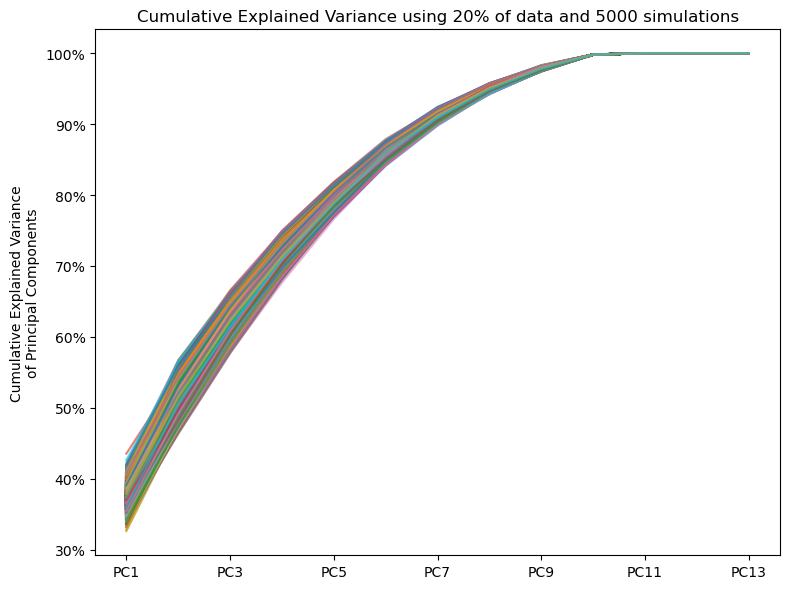

In [16]:
def plot_cumulative_exp_ratio_simulation(df_pca_sim: pd.DataFrame, n_sims: int = 5_000, test_size: float = 0.2) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (8,6))
    
    (df_pca_sim.pivot(
        index = "pc", columns = "sim", values = "exp_var").
        reset_index().
        assign(pc_num = lambda x: x.pc.str.replace("PC", "").astype(int)).
        sort_values("pc_num").
        drop(columns = ["pc_num"]).
        set_index("pc").
        cumsum().
        plot(
            ax     = axes,
            legend = False,
            alpha  = 0.6,
            xlabel = "",
            ylabel = "Cumulative Explained Variance\nof Principal Components",
            title  = "Cumulative Explained Variance using {}% of data and {} simulations".format(
                round(test_size * 100),
                n_sims)))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.tight_layout()

plot_cumulative_exp_ratio_simulation(df_pca_sim, 5_000, 0.2)

Now compare the worst performing and the best performance strategy based on number of PC using ex-post sharpe.

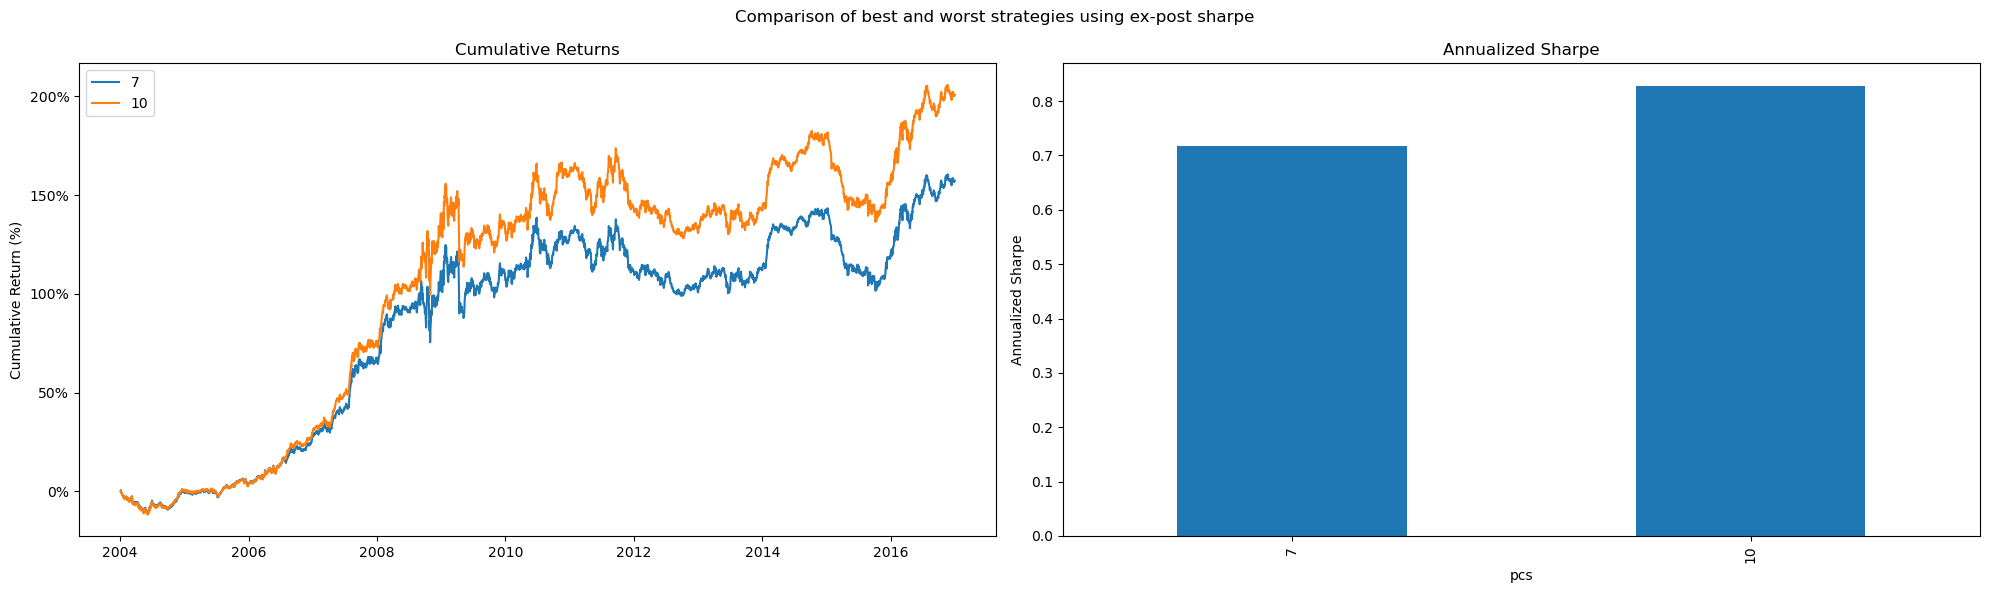

In [18]:
def plot_comparison(df_signal: pd.DataFrame) -> plt.Figure: 

    df_signal_rtn = (df_signal.assign(
        signal_rtn = lambda x: -1 * np.sign(x.lag_resid) * x.rtn))
    
    df_sharpe = (df_signal_rtn[
        ["pcs", "signal_rtn"]].
        groupby("pcs").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        query("sharpe == sharpe.min() | sharpe == sharpe.max()"))
    
    pcs = df_sharpe.index.to_list()
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    
    (df_signal_rtn.query(
        "pcs == @pcs")
        [["date", "signal_rtn", "pcs"]].
        rename(columns = {"pcs": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes[0],
            ylabel = "Cumulative Return (%)",
            xlabel = "",
            title  = "Cumulative Returns"))
    
    (df_sharpe[
        ["sharpe"]].
        plot(
            kind   = "bar",
            legend = False,
            ax     = axes[1],
            ylabel = "Annualized Sharpe",
            title  = "Annualized Sharpe"))
    
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    fig.suptitle("Comparison of best and worst strategies using ex-post sharpe")
    plt.tight_layout()

plot_comparison(df_signal)

In [19]:
def _min_max(df: pd.DataFrame) -> pd.DataFrame: 

    return(pd.concat([
        df.query("signal_rtn == signal_rtn.min()").assign(group = "worst").head(1),
        df.query("signal_rtn == signal_rtn.median()").assign(group = "median").head(1),
        df.query("signal_rtn == signal_rtn.max()").assign(group = "best").head(1)]))

def get_daily_best_worst_strategies(df_signal: pd.DataFrame) -> plt.Figure: 
    
    df_out = (df_signal.assign(
        signal_rtn = lambda x: -1 * np.sign(x.lag_resid) * x.rtn).
        groupby("date").
        apply(_min_max, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]))

    return df_out

df_best_worst = get_daily_best_worst_strategies(df_signal)

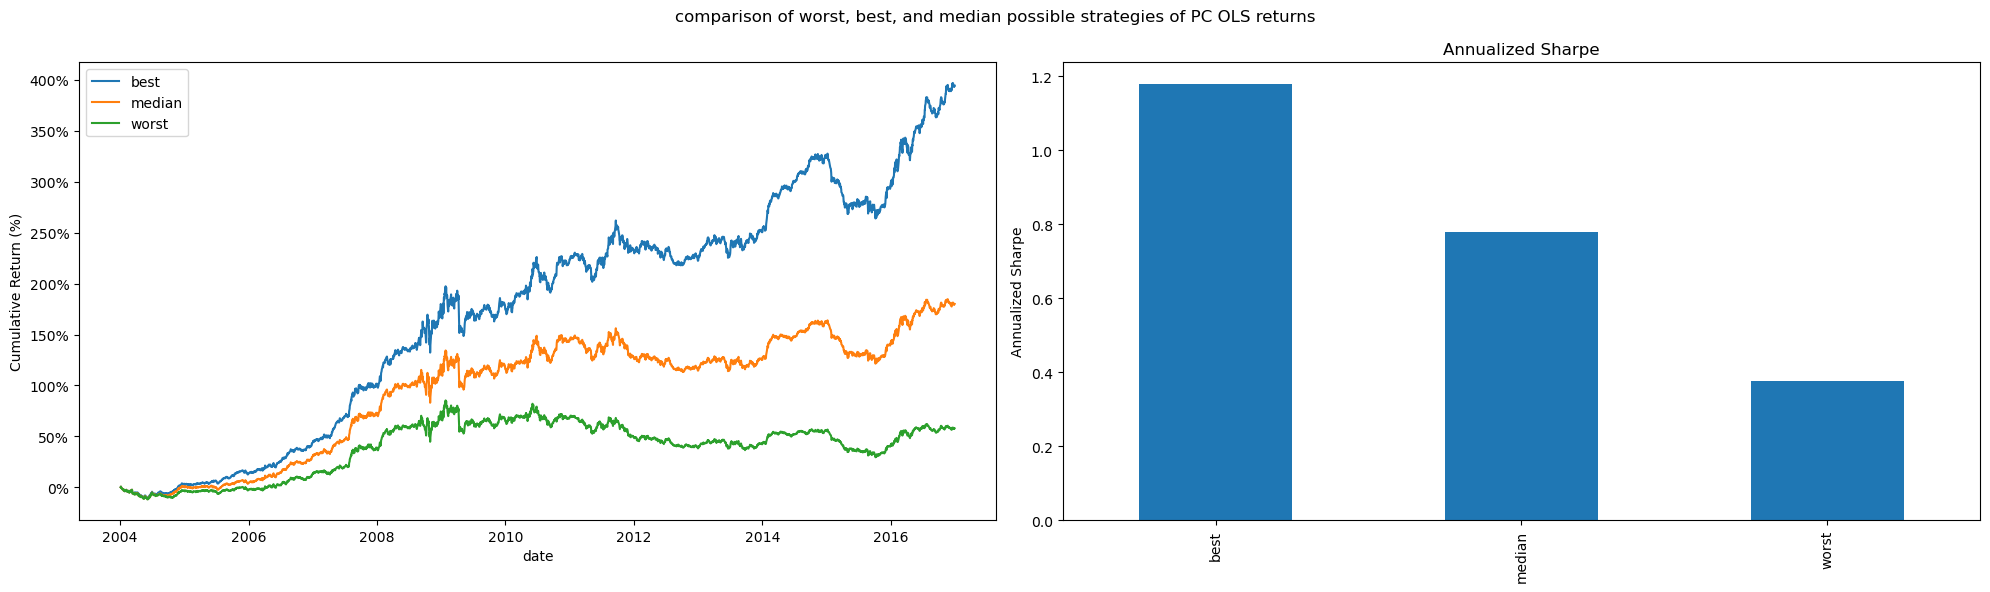

In [20]:
def plot_best_worst(df_best_worst: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    
    (df_best_worst[
        ["date", "signal_rtn", "group"]].
        rename(columns = {"group": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes[0],
            ylabel = "Cumulative Return (%)"))
    
    (df_best_worst[
        ["signal_rtn", "group"]].
        groupby("group").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        plot(
            ax    = axes[1], 
            kind   = "bar",
            ylabel = "Annualized Sharpe",
            xlabel = "",
            legend = False,
            title  = "Annualized Sharpe"))
    
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    fig.suptitle("comparison of worst, best, and median possible strategies of PC OLS returns")
    plt.tight_layout()

plot_best_worst(df_best_worst)

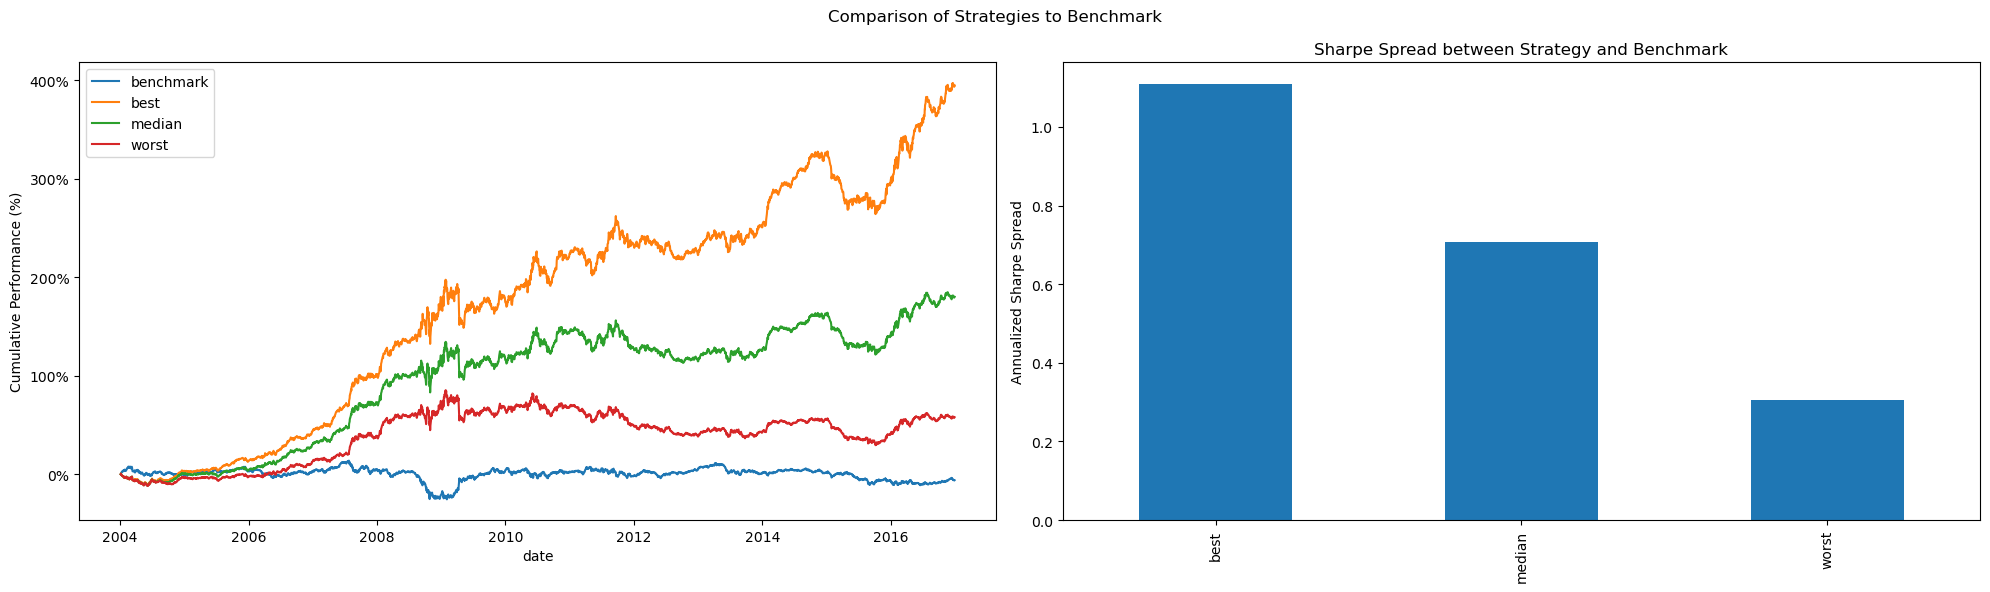

In [21]:
def plot_best_worst_benchmark_comparison(df_best_worst: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_best_worst[
        ["date", "signal_rtn", "group"]].
        rename(columns = {"signal_rtn": "rtn"}))
    
    df_benchmark = (PCAModel().get_misc_indices()[
        ["date", "rtn"]].
        assign(group = "benchmark").dropna())
    
    df_combined = pd.concat([df_tmp, df_benchmark])
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    
    (df_combined.rename(
        columns = {"group": ""}).
        pivot(index = "date", columns = "", values = "rtn").
        dropna().
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[0],
            ylabel = "Cumulative Performance (%)",
            title  = ""))
    
    (df_combined.drop(
        columns = ["date"]).
        groupby("group").
        agg(["mean", "std"])
        ["rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        T.
        reset_index(drop = True).
        melt(id_vars = "benchmark").
        assign(sharpe_spread = lambda x: x.value - x.benchmark).
        set_index("group")
        [["sharpe_spread"]].
        plot(
            kind   = "bar",
            ax     = axes[1],
            legend = False,
            ylabel = "Annualized Sharpe Spread",
            xlabel = "",
            title  = "Sharpe Spread between Strategy and Benchmark"))
    
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    fig.suptitle("Comparison of Strategies to Benchmark")
    plt.tight_layout()

plot_best_worst_benchmark_comparison(df_best_worst)

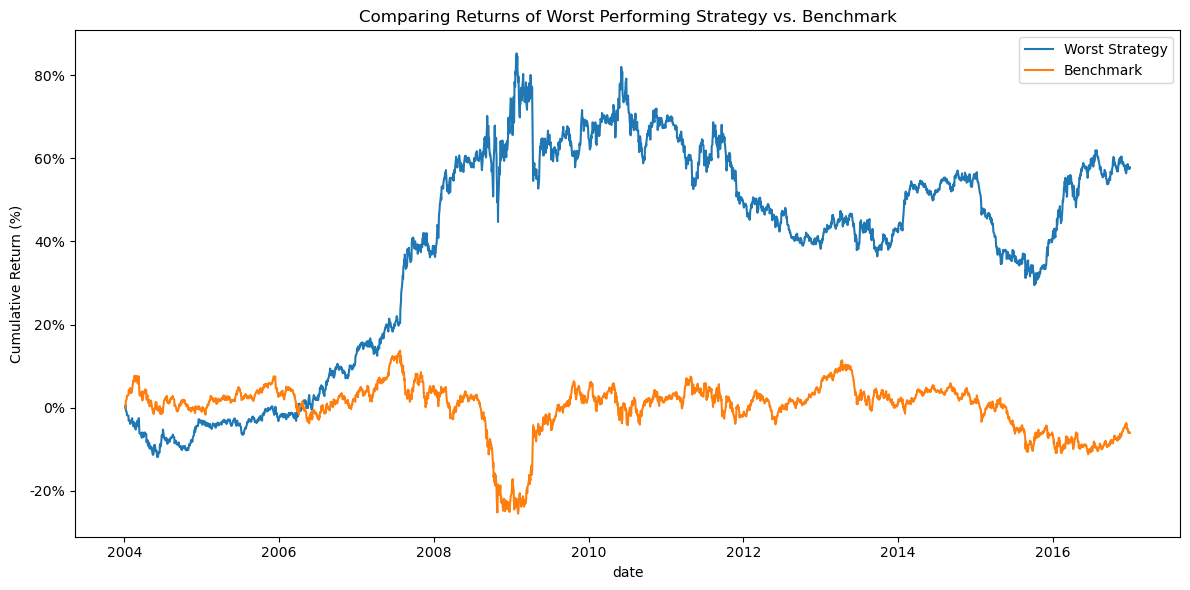

In [22]:
def plot_worst_comparison(df_best_worst: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    df_benchmark = (PCAModel().get_misc_indices()[
        ["date", "rtn"]].
        assign(group = "benchmark").dropna())
    
    (df_best_worst.query(
        "group == 'worst'")
        [["date", "signal_rtn"]].
        merge(right = df_benchmark, how = "inner", on = ["date"]).
        drop(columns = ["group"]).
        rename(columns = {
            "signal_rtn": "Worst Strategy",
            "rtn"       : "Benchmark"}).
        set_index("date").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes,
            title  = "Comparing Returns of Worst Performing Strategy vs. Benchmark",
            ylabel = "Cumulative Return (%)"))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.tight_layout()

plot_worst_comparison(df_best_worst)

In [23]:
def get_regression_setup(df_best_worst: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_best_worst[
        ["date", "rtn", "signal_rtn", "group"]].
        pivot(index = ["date", "rtn"], columns = "group", values = "signal_rtn").
        reset_index().
        rename(columns = {"rtn": "benchmark"}).
        assign(date = lambda x: pd.to_datetime(x.date)).
        set_index("date").
        apply(lambda x: np.cumprod(1 + x)).
        apply(lambda x: x * 1_000_000).
        resample("1ME").
        first().
        pct_change().
        reset_index().
        melt(id_vars = ["date", "benchmark"]).
        rename(columns = {"value": "signal_rtn"}).
        dropna())

    return df_out

df_regression = get_regression_setup(df_best_worst)

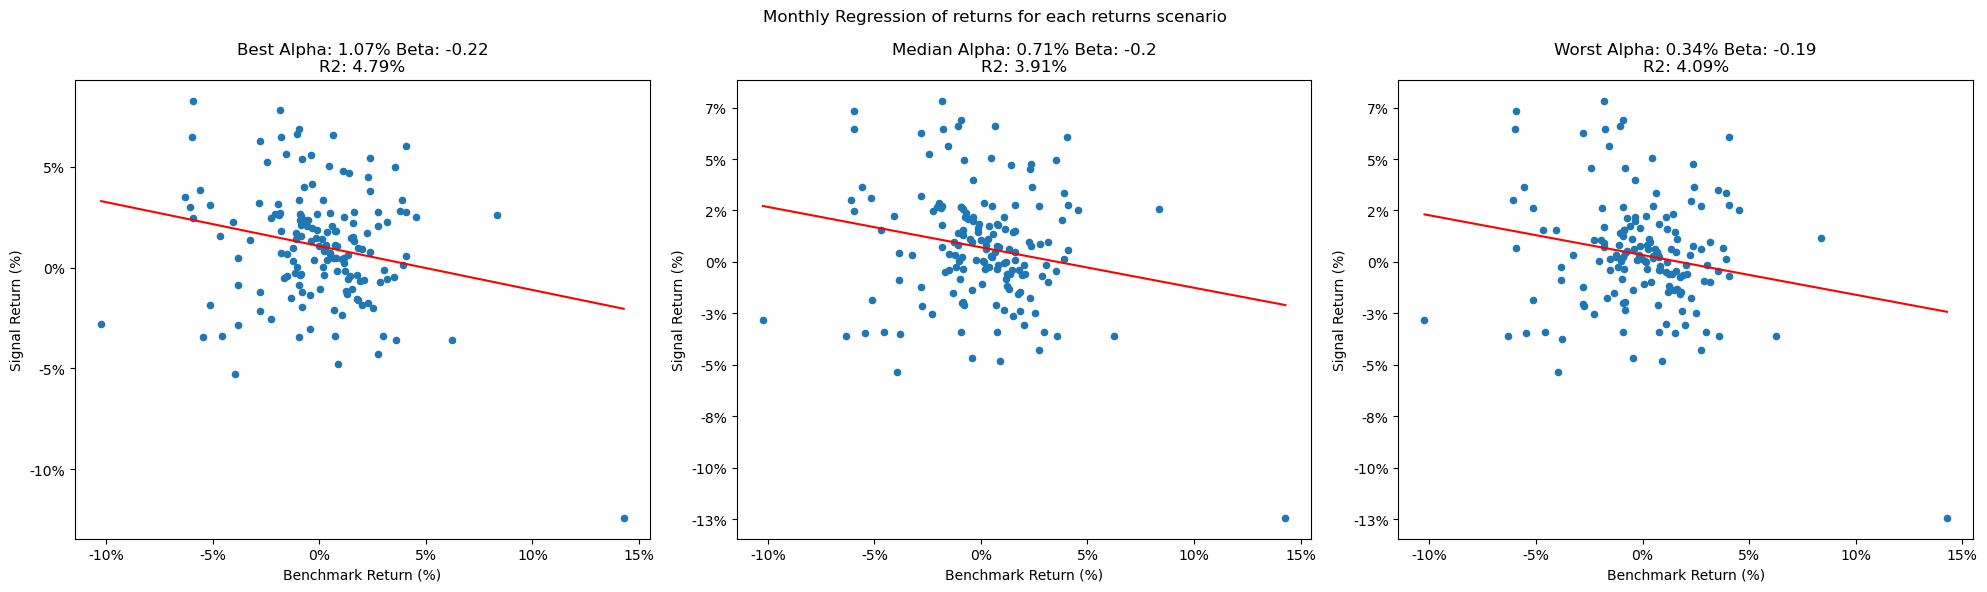

In [24]:
def plot_regression(df_regression: pd.DataFrame) -> plt.Figure: 

    groups    = df_regression.group.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(groups), figsize = (20,6))
    
    for group, ax in zip(groups, axes.flatten()):
    
        df_tmp = (df_regression.query(
            "group == @group").
            drop(columns = ["group"]).
            set_index("date"))
    
        model = (sm.OLS(
            endog = df_tmp.signal_rtn,
            exog  = sm.add_constant(df_tmp.benchmark)).
            fit())
    
        alpha, beta = model.params
        rsquared    = model.rsquared
    
        (df_tmp.plot(
            ax     = ax,
            kind   = "scatter",
            x      = "benchmark",
            y      = "signal_rtn",
            ylabel = "Signal Return (%)",
            xlabel = "Benchmark Return (%)",
            title  = "{} Alpha: {}% Beta: {}\nR2: {}%".format(
                group.capitalize(),
                round(alpha * 100, 2),
                round(beta, 2),
                round(rsquared * 100, 2))))
    
        x = np.linspace(
            start = df_tmp.benchmark.min(), 
            stop  = df_tmp.benchmark.max(), 
            num   = 1_000)
    
        y = (x * beta) + alpha
        ax.plot(x, y, color = "red")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    
    fig.suptitle("Monthly Regression of returns for each returns scenario")
    plt.tight_layout()

plot_regression(df_regression)